In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import random
from PIL import Image, ImageDraw
from IPython.display import display, HTML #Para mostrar aqui mismo
from collections import Counter
import cv2 # Para el ruido
from scipy.signal import convolve2d
import math

In [2]:
#Ploteo de imagenes

def plot(image,numIm,pos,title):
    plt.subplot(1,numIm,pos)
    plt.imshow(image)
    plt.title(title)
    plt.tight_layout()



In [3]:
#Lectura de Imagenes 
plt.rcParams['image.cmap'] = 'gray'
%matplotlib inline
circuito = Image.open("ImagenesFiguras/circuit2.png").convert('L')
lena = Image.open("ImagenesFiguras/lenag.bmp").convert('L')

# 1) Utiliza la imagen del circuito, generale ruido gaussiano aditivo con media cero y desviación est ́andar de 0.04. Filtra la imagen primero con un filtro promedio aritm ́etico de tamaño 3 × 3, y luego filtrala con un filtro promedio geom ́etrico del mismo tamaño. Comparalos (genera así la figura 5.7 del libro de Gonzalez et. al.)

In [4]:
#Filtros, ruidos y mas

def convolution(img,kernell):
    iHeight = img.shape[0]
    iWidth = img.shape[1]
    fill = (kernell.shape[0]-1)//2
    matrix = np.zeros((iHeight,iWidth))
    
    for i in range(fill, iHeight -fill):
        for j in range(fill, iWidth-fill):
            pixel_value = 0
            for x in range(-fill,fill+1):
                for y in range(-fill,fill +1):
                    pixel = img[i+x][j+y]
                    kernel= kernell[fill+x][fill +y]
                    pixel_value += (kernel*pixel)
            matrix[i][j]=pixel_value
    return matrix

def filtro_paso_bajas(img, kernell):
    matrix_img = np.array(img)
    matrix_res = convolution(matrix_img, kernell)
    nueva_img = Image.fromarray(matrix_res).convert('L')
    return nueva_img

def ruido_gaussiano(img, mean=0, stddev=40):
    img_array = np.array(img, dtype=np.uint8)
    noise = np.random.normal(mean, stddev, img_array.shape)
    imagen_con_ruido = img_array + noise
    imagen_con_ruido = np.clip(imagen_con_ruido, 0, 255)
    imagen_ruido_pil = Image.fromarray(imagen_con_ruido.astype(np.uint8), 'L')
        
    return imagen_ruido_pil

def filtro_aritmetico(n, m):
    return np.ones((n, m), dtype=np.float32) / (n*m)
    

def obtener_vecindad(i, j, matrix, n, m, var):
    vecindad = []
    fill_x = n//2
    fill_y = m//2
    if var !=1:
        for x in range(-fill_x, fill_x+1):
            for y in range(-fill_y, fill_y+1):
                if (i+x) >= 0 and (i+x) < matrix.size[0] and (j+y) >= 0 and (j+y) < matrix.size[1]:
                    valor = matrix.getpixel((i+x,j+y))
                    vecindad.append(valor)
                else:
                    vecindad.append(1)
        prod = 1
        for v in vecindad:
            prod = prod*v

        e = 1 / (n*m)
        resultado = prod ** e

        return resultado
    else:
        for x in range(-fill_x, fill_x+1):
            for y in range(-fill_y, fill_y+1):
                if (i+x) >= 0 and (i+x) < len(matrix) and (j+y) >= 0 and (j+y) < len(matrix[0]):
                    vecindad.append(matrix[i+x][j+y])
                else:
                    vecindad.append(0)
        mean = np.mean(vecindad)
        varianza = np.var(vecindad)
    
        return mean, varianza
        
                

def filtro_geometrico(n, m, image):
    new_image = Image.new('L', image.size)
    for i in range(image.size[0]):
        for j in range(image.size[1]):
            new_value = obtener_vecindad(i, j, image, n, m, 0)
            new_image.putpixel((i,j), round(new_value))

    return new_image



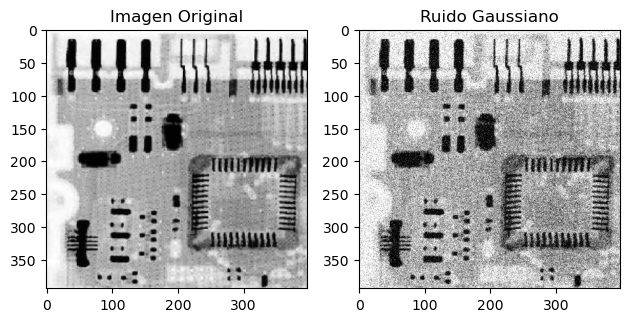

In [5]:
#Aplicamos filtro
circuito_gaussiano = ruido_gaussiano(circuito)
aritmetica3x3 = filtro_aritmetico(3,3)
im_aritmetica = filtro_paso_bajas(circuito_gaussiano,aritmetica3x3)
plot(circuito,2,1,"Imagen Original")
plot(circuito_gaussiano,2,2,"Ruido Gaussiano")

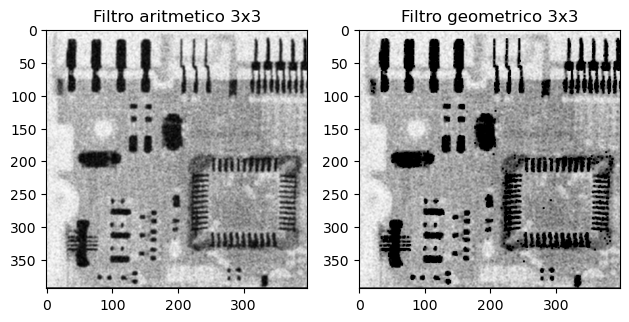

In [6]:
#Aplicamos filtro geometrico
geo_img = filtro_geometrico(3,3,circuito_gaussiano)
plot(im_aritmetica,2,1,"Filtro aritmetico 3x3")
plot(geo_img,2,2,"Filtro geometrico 3x3")

# 2) Utiliza nuevamente la imagen circuito, generale ruido gaussiano aditivo de media cero y desviación estándar de 0.04. Filtrala primero con un filtro promedio aritmético de tamaño 7 × 7. Filtrala ahora con un filtro geométrico del mismo tamaño. Finalmente filtrala con un filtro adaptativo para reducción de ruido del mismo tamaño que los anteriores. Comparalos

In [7]:

def filtro_adaptativo(n,m,img):
    media_arr = np.zeros(img.shape)
    var_arr = np.zeros(img.shape)
    
    for i in range(len(img)):
        for j in range(len(img[0])):
            current_media, current_var = obtener_vecindad(i,j,img,n,m,1)
            media_arr[i][j] = current_media
            var_arr[i][j] = current_var
    ruido_var = np.mean(var_arr)
    for x in range(len(var_arr)):
        for y in range(len(var_arr[0])):
            if ruido_var > var_arr[x][y]:
                var_arr[x][y]= ruido_var
    exp1 = ruido_var/var_arr # varianza del ruido / varianza local
    exp2 = img - media_arr # image original - media local
    
    new_img = img - (exp1*exp2)
    
    return Image.fromarray(new_img.astype(np.uint8), 'L')
    
    
        

In [8]:
aritmetica7x7= filtro_aritmetico(7,7)
im_art7x7 = filtro_paso_bajas(circuito_gaussiano,aritmetica7x7)
geo_img7x7 = filtro_geometrico(7,7,circuito_gaussiano)
adap_img = filtro_adaptativo(7,7,np.array(circuito_gaussiano))

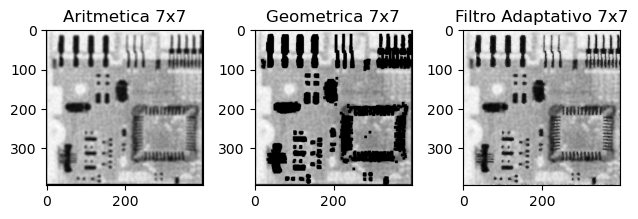

In [9]:
plot(im_art7x7,3,1,"Aritmetica 7x7")
plot(geo_img7x7,3,2,"Geometrica 7x7")
plot(adap_img,3,3,"Filtro Adaptativo 7x7")

# 3) Utiliza la imagen circuito, generale un ruido sal y pimienta aditivo con probabilidades Pa = Pb = 0.25. Filtrala primero con un filtro mediana de tamaño 7 × 7. Filtrala ahora con un filtro mediana adaptativo con Smax = 7. Comparalos

In [10]:
#Ruido sal y pimienta
def rSalPim(imagen,dtype=np.uint8):
    arr = np.array(imagen)
    s= arr.copy()/255
    y, x= len(arr), len(arr[0])
    pimienta=0.05
    sal= 1- pimienta
    for ren in range(y):
        for col in range(x):
            rnd= np.random.random()
            if rnd < pimienta:
                s[ren][col]=0
            elif rnd > sal:
                s[ren][col]=1
    return s

def vencidad_mediana(i,j,img,n):
    return

    

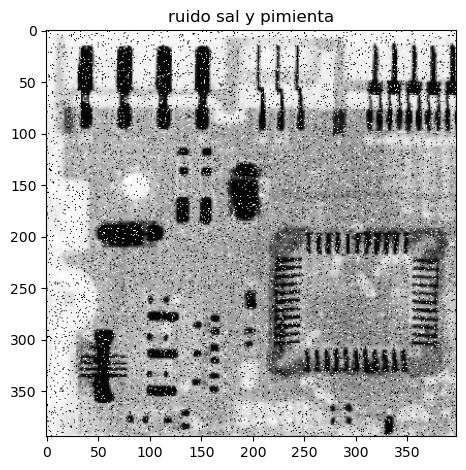

In [11]:
circuito_syp = rSalPim(circuito)
plot(circuito_syp,1,1,"ruido sal y pimienta")

# 4) Para la imagen lena con ruido aditivo de tipo gausiano, encontrar el filtro de Wiener y restaurar la imagen.

In [20]:
lena_arr = np.array(lena)
lena_gaus = ruido_gaussiano(lena)
lena_gausTf = np.fft.fft2(np.array(lena_gaus)) # == F_noisy
lenaTf= np.fft.fft2(lena_arr) # == F_original
lenasTf = np.fft.fftshift(lenaTf)

def get_lgTf():
    return lena_gausTf

def get_lTf():
    return lenaTf

def fft2(img):
    imgTF = np.fft.fft2(img)
    return imgTF

def fase(img):
    fase_Tf= np.angle(img) #Fase
    return fase_Tf
def amplitud(img):
    parte_realTf = abs(img) #Amplitud
    return parte_realTf
def ifft(img):
    ift = np.fft.ifftshift(img)
    ift = np.fft.ifft2(ift)
    
    return ift

In [13]:
def ruido_var(img):
    ruido = img-np.mean(img)
    return ruido
def wiener_filter(original,gaus):
    ruido = ruido_var(gaus)
    ruidoTf = np.fft.fft2(ruido)
    amp_gaus = amplitud(gaus)
    amp_or = amplitud(original)
    amp_ru = amplitud(ruidoTf)
    
    filtro_wiener = amp_or/(amp_or+amp_ru)
    im_wiener = filtro_wiener*gaus
    im_wiener = np.fft.ifft2(im_wiener)
    im_wiener = np.real(im_wiener)
    im_wiener = np.clip(im_wiener,0,255)
    
    return Image.fromarray(im_wiener.astype(np.uint8), 'L')

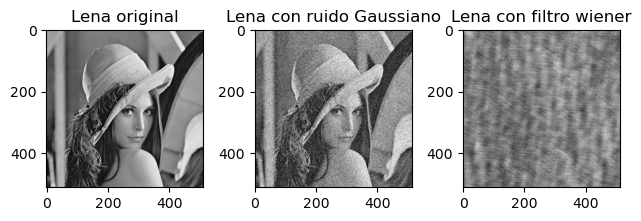

In [14]:
wiener_lena = wiener_filter(lenaTf,lena_gausTf)
plot(lena,3,1,"Lena original")
plot(lena_gaus,3,2,"Lena con ruido Gaussiano")
plot(wiener_lena,3,3,"Lena con filtro wiener")

# 5) Encontrar el filtro de Wiener y restaurar una imagen lena que ha sido sometida a un proceso de pérdida de nitidez. La imagen con perdida de nitidez se obtiene filtrando una imagen nítida y libre de ruido con un filtro paso bajas de tamaño 9x9 normalizado (filtro promedio ponderado).

In [15]:
def wiener_nitidez(im_or, img_gau):
    imTf = ifft(im_or)
    imgTf = ifft(img_gau)
    filtro = 1/(imgTf/imTf)
    
    img_final = filtro * imgTf
    img_final = np.fft.ifft2(img_final)
    img_final = np.real(img_final)
    img_final = np.clip(img_final,0,255)
    
    return Image.fromarray(img_final.astype(np.uint8),'L')

#Creamos un filtro 9x9
filtro9x9 = weights = np.array([
    [1, 1, 1, 2, 2, 2, 1, 1, 1],
    [1, 1, 1, 2, 2, 2, 1, 1, 1],
    [1, 1, 1, 2, 2, 2, 1, 1, 1],
    [2, 2, 2, 4, 4, 4, 2, 2, 2],
    [2, 2, 2, 4, 4, 4, 2, 2, 2],
    [2, 2, 2, 4, 4, 4, 2, 2, 2],
    [1, 1, 1, 2, 2, 2, 1, 1, 1],
    [1, 1, 1, 2, 2, 2, 1, 1, 1],
    [1, 1, 1, 2, 2, 2, 1, 1, 1]
], dtype=np.float64)

filtro9x9 = filtro9x9/filtro9x9.sum()
    

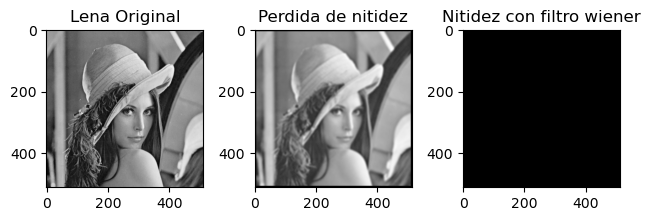

In [21]:
lena_nitidez = filtro_paso_bajas(lena,filtro9x9)
lena_nit_wiener = wiener_nitidez(np.array(lena),np.array(lena_gaus))
plot(lena,3,1,"Lena Original")
plot(lena_nitidez,3,2,"Perdida de nitidez")
plot(lena_nit_wiener,3,3,"Nitidez con filtro wiener")

# 6) Para una imagen lena a la que se le ha agregado ruido de tipo gausiano y posteriormente ha perdido nitidez, encontrar el filtro de Wiener y restaurarla.

In [29]:
def wiener2(orig, gaus):
    gausTf = np.fft.fft2(gaus)
    origTf = np.fft.fft2(orig)
    ruido = ruido_var(gaus)
    ruidoTf = np.fft.fft2(ruido)
    amp_ga = np.abs(gausTf)
    amp_or = np.abs(origTf)
    amp_ru = np.abs(ruidoTf)
    filtro1 = amp_or / (amp_or + amp_ru)
    filtro2 = 1 / (gausTf / origTf)
    wiener_filter = filtro1*filtro2

    im_final = wiener_filter * gaus
    im_final = np.fft.ifft2(im_final)
    im_final = np.real(im_final)
    im_final = np.clip(im_final, 0, 255)

    return Image.fromarray(im_final.astype(np.uint8), 'L')

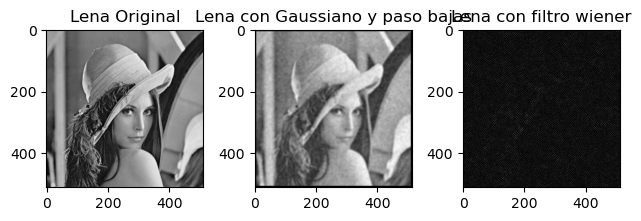

In [32]:
lenaRn = filtro_paso_bajas(lena_gaus,filtro9x9)
lena_wiener2 = wiener2(lena, lenaRn)
plot(lena,3,1,"Lena Original")
plot(lenaRn,3,2,"Lena con Gaussiano y paso bajas")
plot(lena_wiener2,3,3,"Lena con filtro wiener")